# Understanding Board Game Reviews

### Setting the scene

In this notebook, we investigate a data set concerning board-games, compiled by Markus Shepherd from [Board Game Atlas](https://www.boardgameatlas.com/), found on Kaggle [here](https://www.kaggle.com/mshepherd/board-games).  
We initially do some high-level exploratory analysis, followed by a brief attempt to see whether a linear regression model can claim some low-hanging fruit.

Summary:

We find that:
- age-rating and time-recommendations are related.
- some publishers tends to create less well-rated games.
- while some progress can be acheived through using categorical variables, predicting rating based off this data set is only partially affective.

### Getting set up

First we import the libraries that we might need and take a glimpse at the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import plotly.express as px
import json
%matplotlib inline

In [2]:
df = pd.read_csv('./BGG.csv')
df.head()

,bgg_id,name,year,game_type,designer,artist,publisher,min_players,max_players,min_players_rec,...,stddev_rating,bayes_rating,complexity,language_dependency,bga_id,dbpedia_id,luding_id,spielen_id,wikidata_id,wikipedia_id
0,NaN,Sword and Sail,2004.0,NaN,Big Little Games,NaN,Andrew Jaster Multimedia Design,2.0,5.0,NaN,...,NaN,NaN,NaN,NaN,002IJykbze,NaN,NaN,NaN,NaN,NaN
1,NaN,Charon,1996.0,NaN,Andreas Lenz,Andreas Lenz,Gamin,2.0,4.0,NaN,...,NaN,NaN,NaN,NaN,007646Mm8B,NaN,NaN,NaN,NaN,NaN
2,NaN,Fotbolls-MIG,2010.0,NaN,NaN,NaN,Compete Now,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,007nZoHMje,NaN,NaN,NaN,NaN,NaN
3,NaN,Scout: Mein erstes Taschengeld,2016.0,NaN,Kai Haferkamp,NaN,KOSMOS,2.0,4.0,NaN,...,NaN,NaN,NaN,NaN,009PRyhvqH,NaN,NaN,NaN,NaN,NaN
4,NaN,Warp 6,2002.0,NaN,"Greg Lam,Luke Weisman Miratrix,Brian Tivol",NaN,"Magellan,Pair-of-Dice Games",2.0,3.0,NaN,...,NaN,NaN,NaN,NaN,00AI3sb84B,NaN,NaN,NaN,NaN,NaN


We look to see how many columns are completely empty and remove those columns

In [3]:
empty_columns = df.isna().all()
df_dropped = df.dropna(how='all', axis=1)
print("There are {} completely empty columns, we remove these, leaving us with {} columns.".format(
                                                sum(empty_columns),sum(~empty_columns)))
print("There are {} games in the initial dataset.".format(df.shape[0]))

There are 23 completely empty columns, we remove these, leaving us with 15 columns.
There are 113997 games in the initial dataset.


The *category* and *mechanic* columns in the data are in an encoded format, here we load in the readable names

In [4]:
cats  = pd.read_json('./categories.json',orient='records')[['id','name']].set_index('id')
mechs = pd.read_json('./mechanics.json', orient='records')[['id','name']].set_index('id')

In [5]:
print('Our remaining 15 columns are:')
print(df_dropped.columns.to_list())

Our remaining 15 columns are:
['name', 'year', 'designer', 'artist', 'publisher', 'min_players', 'max_players', 'min_age', 'min_time', 'max_time', 'category', 'mechanic', 'num_votes', 'avg_rating', 'bga_id']


### Possible questions

With this dataset, a few possible questions spring to mind:
    1. Is minimum age correlated with min/max time? 
        - i.e. are games created with younger players in mind designed to be shorter
    2. Are certain publishers rated more highly than others?
    3. Are certain categories/mechanics rated more highly than others?
    4. Are we able to predict a rating using other variables in the dataset?
        - For example, this may be useful to provide an estimated rating for a game which is new to the site.
        
Let's dive in with the first one...

### Are minimum-age and play-time related?

We can see below that each of the relevant variables have a few outliers at very high values, to stop these values skewing later analysis we will cap the time-variables at their 95th percentile and the age variable at 18-years-old.

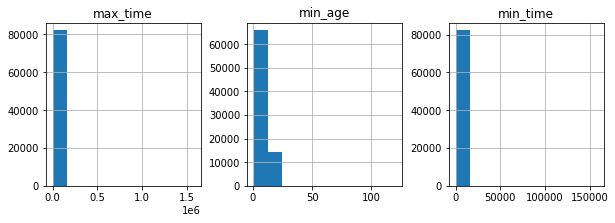

In [6]:
df.hist(column=['min_age','min_time','max_time'], layout=(1,3), figsize=(10,3));

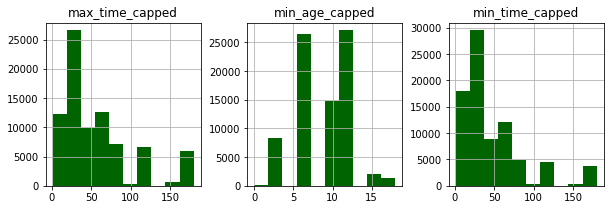

In [7]:
# Cap the time and bucket & cap the age
max_time_cap = df.max_time.quantile(0.95)
# Age capped at 18 and bucketed into bins of 3 width
df['min_age_capped'] = df.min_age.apply(lambda x: np.floor(min(x,18)/3)*3) 
df['max_time_capped'] = df.max_time.apply(lambda x: min(x,max_time_cap))
# We cap the min_time and the *max_time* 0.95 percentile also to make it easier to compare the two
df['min_time_capped'] = df.min_time.apply(lambda x: min(x,max_time_cap)) 

df_counts = df['min_age_capped'].value_counts().sort_index()

df.hist(column=['min_age_capped','min_time_capped','max_time_capped'], layout=(1,3), figsize=(10,3), color = 'darkgreen');

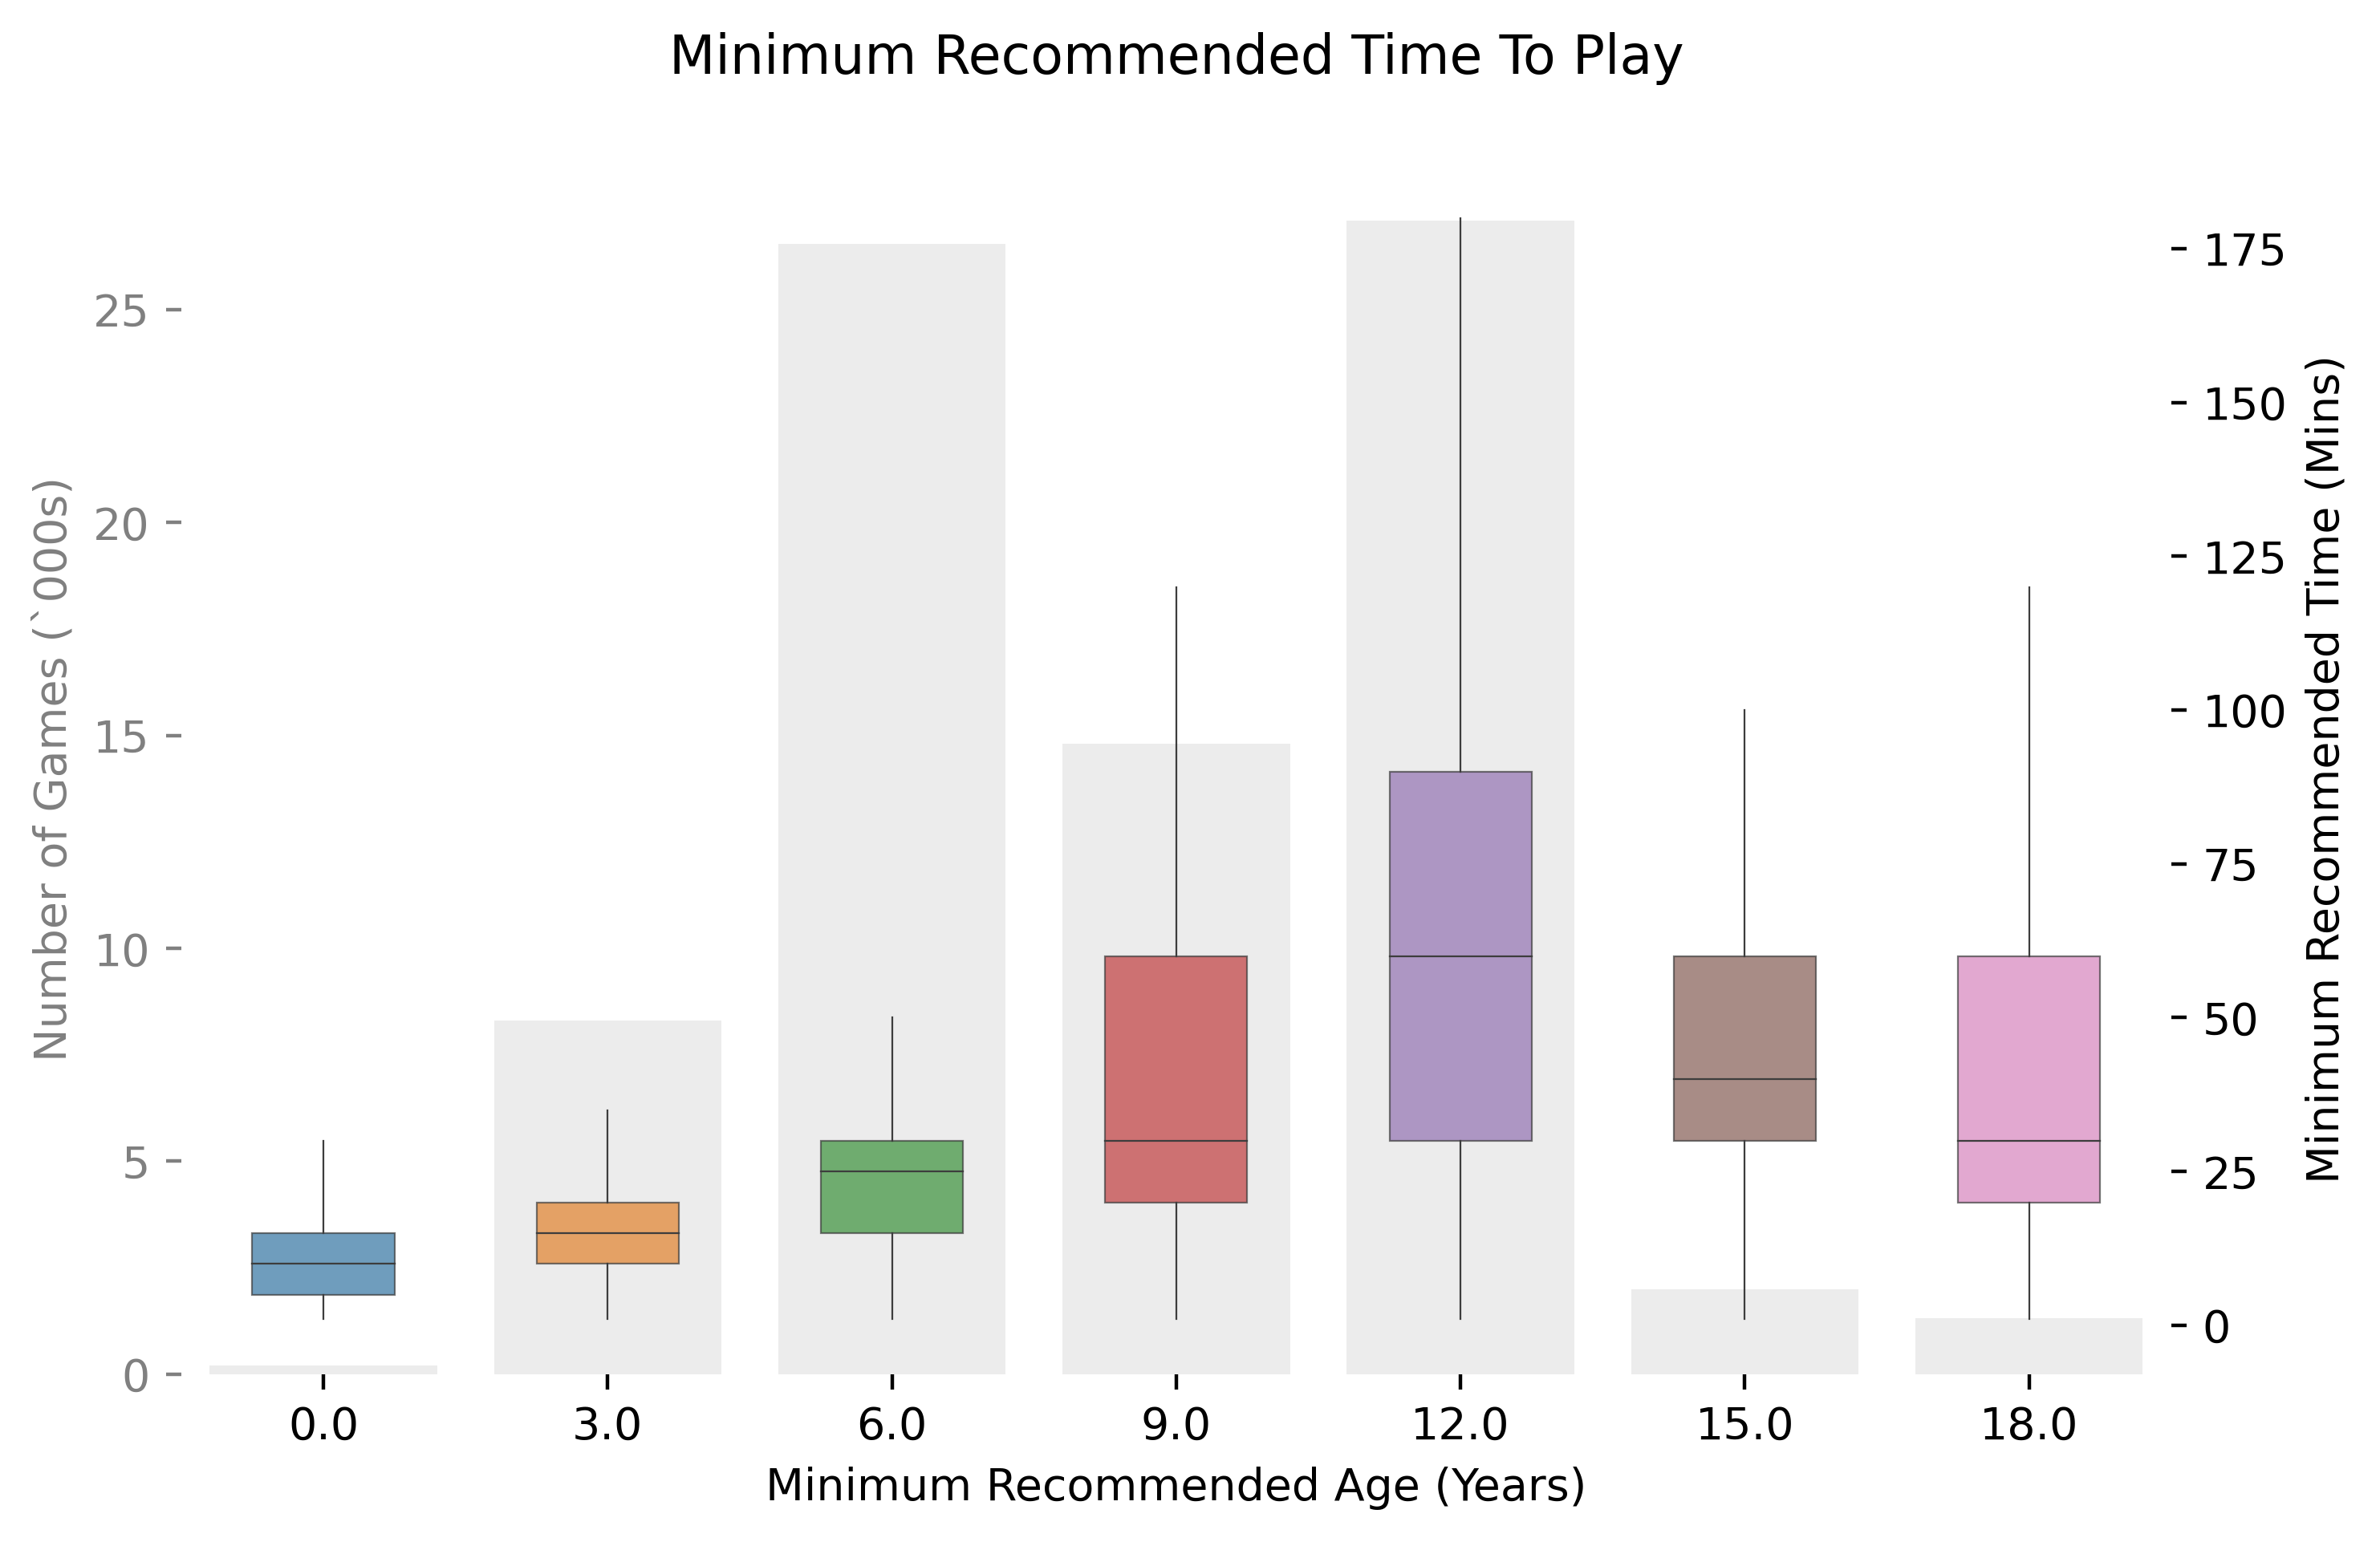

In [8]:
# Setup plots
fig,ax = plt.subplots(1,1, figsize=(8,5), dpi = 400)
ax_b = ax.twinx() # Second y axes for plot 0

# Plotting
sns.barplot(x= df_counts.index, y = df_counts.values/1000
                              ,  ax = ax, color='grey'
                              , alpha=0.15)

sns.boxplot(x="min_age_capped", y="min_time_capped"
                              , data=df
                              , boxprops=dict(alpha=.7)
                              , ax = ax_b
                              , fliersize=1
                              , width = 0.5
                              , linewidth=0.4
                              , showcaps = False
                              , showfliers=False)


# Cleanup of plots
sns.despine(left=True, bottom=True)
ax_b.set_ylabel('Minimum Recommended Time (Mins)') # Relabel y
ax.set_xlabel('Minimum Recommended Age (Years)')  # Relabel x
ax.set_ylabel('Number of Games (`000s)', color='grey') # Relabel y
ax.tick_params(axis='y', colors='grey')
ax.tick_params(axis='x', bottom='off') # Turn off ticks on x
ax.set_title('Minimum Recommended Time To Play', pad=20);  # Relabel x
# Save output
plt.savefig('output_age_vs_time.png')


In the plot above we also show the number of games in each age-bucket (in grey).

It appears that the suggested minimum-play-time increases with recommended age, at least up to 12-years.  After this point it appears to decrease again.  We appreciate that there is a smaller sample size for recommended ages older than 12 years, however, it is still in the thousands so we are happy to infer patterns from those ranges.

One reason for this might be that for a game to be rated as either 15+ or 18+, it is likely to be a game of a more adult nature (perhaps an after-dinner game) and so is likely to be designed to be played more quickly that a classic board-game.

# Publishers with Ratings

We now move onto question 2 of the set above, and we must reduce the dataset down to just those games that have a rating.  We also only concern ourselves with publishers that have created >1% of the games in the rated set, so that we are investigating a maneagable number of publishers.

In [9]:
df_rated = df.dropna(subset=['avg_rating'])
print("There are {} games with a rating, out of {} in the dataset".format(df_rated.shape[0], df.shape[0]))

There are 3578 games with a rating, out of 113997 in the dataset


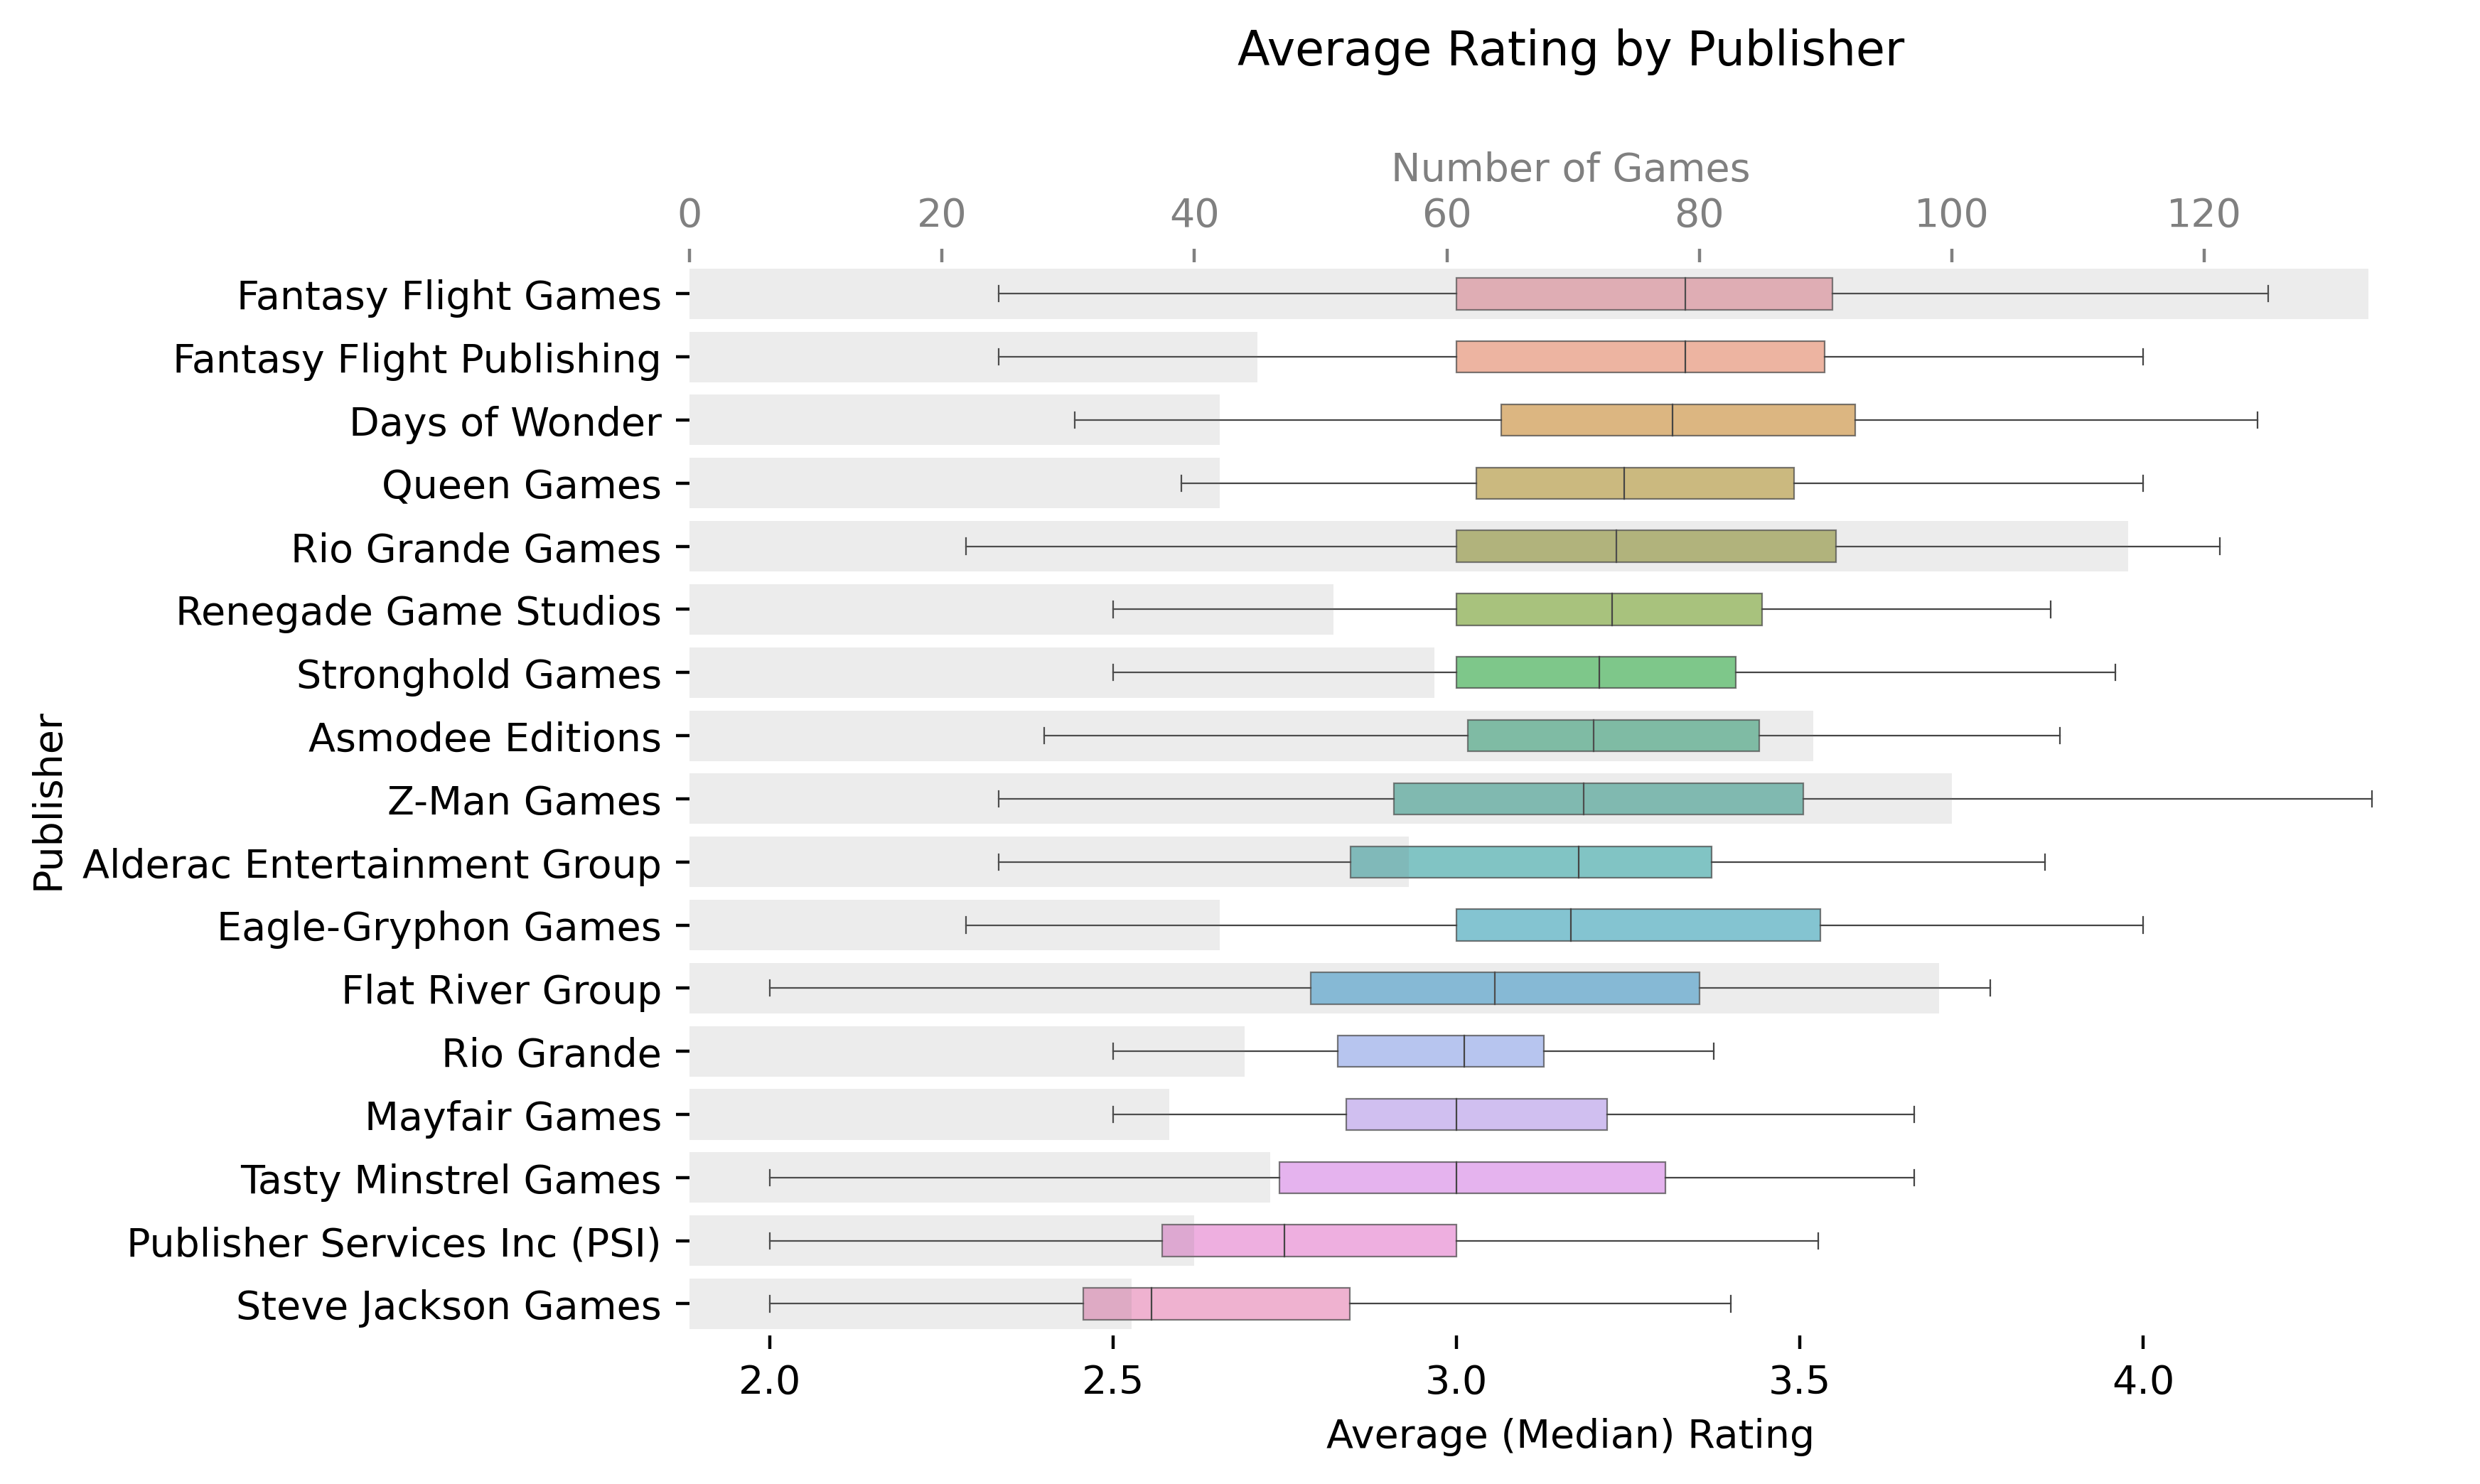

In [10]:
# Publishers with > 1% of the games in the rated set
frequent_publisher = df_rated.publisher.value_counts(normalize=True) > 0.01
frequent_publisher = frequent_publisher[frequent_publisher].index.to_list()

df_top_pub_with_rating = df_rated[df_rated.publisher.isin(frequent_publisher)]
df_counts_pub = df_top_pub_with_rating['publisher'].value_counts().sort_index()

# Order for the chart (highest rated at the top)
publisher_order = df_top_pub_with_rating[['publisher','avg_rating']].groupby('publisher').median()
publisher_order = publisher_order.sort_values(by='avg_rating', ascending=False).index

# Initiate plot
fig,ax = plt.subplots(1,1,figsize = (8,5), dpi = 400)
ax_b = ax.twiny() # Second y axes for plot 0

# Plot
sns.barplot(y=df_counts_pub.index, x=df_counts_pub.values
                                 , ax = ax_b, color='grey'
                                 , alpha=0.15
                                 , order = publisher_order)

sns.boxplot(y="publisher", x="avg_rating"
                         , data=df_top_pub_with_rating
                         ,  boxprops=dict(alpha=.7)
                         , ax=ax
                         , fliersize=1
                         , order = publisher_order
                         , width =0.5
                         , linewidth=0.4
                         , showfliers=False)

# Cleanup of plot
sns.despine(left=True, bottom=True)
ax.set_xlabel('Average (Median) Rating')  # Relabel x
ax_b.set_xlabel('Number of Games', color='grey')  # Relabel x
ax_b.spines['top'].set_color('grey')            # Recolor secondary axis
ax_b.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', left='off')
ax.set_ylabel('Publisher') # Relabel y
ax.set_title('Average Rating by Publisher',pad=50);  # Relabel x

# Save output
plt.savefig('output_publishers_vs_rating.png',bbox_inches='tight')


Considering Steve Jackson Games, the lowest rated of the popular games, we see they have a median rating of ~2.5, compared to the top publishers rating of 3.3.  There is one thing we cannot rule out from this one-dimensional slice of the data however, that is - there may be a hidden variable which negatively affects reviews, and which Steve Jacksons Games are particularly prone to (e.g. a certain Category or Mechanic).

## Now to the model

Before we can being to build a model we need to clean the data a little more...

### Cleaning the data

There are many columns in the data that have blank values

In [11]:
# Remove the binning from the age range that we created earlier
df['min_age_capped'] = df.min_age.apply(lambda x: min(x,18)) 
# Cap max players and year as before
df['max_players_capped'] = df.max_players.apply(lambda x: min(x,10)) 
df['year_capped'] = df.year.apply(lambda x: max(x,1990)) 

# Remove all columns with no data in the entire column
# Also drop the bga_id column as it's not useful to us
df_dropped = df.dropna(how='all', axis=1)
df_dropped = df_dropped.drop(['bga_id'],axis=1)
# Drop columns we've already capped
df_dropped = df_dropped.drop(['min_time'],axis=1)
df_dropped = df_dropped.drop(['max_time'],axis=1)
df_dropped = df_dropped.drop(['min_age'] ,axis=1)
df_dropped = df_dropped.drop(['max_players'],axis=1)
df_dropped = df_dropped.drop(['year'],axis=1)

In [12]:
perc_rated = 1-df_dropped.avg_rating.isna().mean()
num_rated = sum(~df_dropped.avg_rating.isna())

print("Only {:.1f}% of games are rated, drop the unrated ones, this leaves us with {} rated games".format(perc_rated*100,num_rated))
df_rated = df_dropped[~df_dropped.avg_rating.isna()]


Only 3.1% of games are rated, drop the unrated ones, this leaves us with 3578 rated games


In [13]:
df_rated.head()

,name,designer,artist,publisher,min_players,category,mechanic,num_votes,avg_rating,min_age_capped,max_time_capped,min_time_capped,max_players_capped,year_capped
72,Poo,Matthew Grau,"Brett Bean,Mike Vaillancourt",Publisher Services Inc (PSI),2.0,NaN,"WPytek5P8l,BGrhzIN69D,T8JEFYwoqy",17,1.764706,6.0,10.0,10.0,2.0,2009.0
165,Ascending Empires,Ian Cooper (I),Chechu Nieto,Z-Man Games,2.0,NaN,lA3KUtVFCy,6,3.333333,10.0,75.0,75.0,4.0,2011.0
199,Clank! A Deck-Building Adventure,Paul Dennen,"Rayph Beisner,Raul Ramos,Nate Storm",Renegade Game Studios,2.0,"KUBCKBkGxV,ZTneo8TaIO","vZsDDAdOoe,BGrhzIN69D,MEAoOygZsA,hmipYN1R1I",225,3.571291,13.0,60.0,30.0,4.0,2012.0
202,Dominion Big Box (English),Donald X. Vaccarino,"Matthias Catrein,Julien Delval,Ryan Laukat,Har...",Rio Grande Games,2.0,NaN,vZsDDAdOoe,8,3.750000,12.0,30.0,30.0,4.0,2010.0
217,El Grande,"Wolfgang Kramer,Richard Ulrich",Doris Matthäus,NaN,2.0,"QAYkTHK1Dd,nuHYRFmMjU","05zCZoLvQJ,bgGxE0pI2B,AZxlPpi5oq,iWODHwRGuU,WP...",89,3.584270,12.0,120.0,60.0,5.0,1995.0


In [14]:
"There are only {} games that contain data for every column".format(df_rated.dropna().shape[0])

'There are only 536 games that contain data for every column'

However, the categorical columns Mechanic and Category account for a large number of these NaNs.  If we accomodate the NaNs in these columns, we effectively 5X our dataset.

In [15]:
cols_to_dropna = df_rated.columns.to_list()
cols_to_dropna.remove('mechanic')
cols_to_dropna.remove('category')
# Remove rows with any NaN, except if they are in Mechanic/Category column
# as we're going to Dummy these columns
df_rated = df_rated.dropna(subset=cols_to_dropna)
"Now we are working with {} games".format(df_rated.shape[0])

'Now we are working with 2404 games'

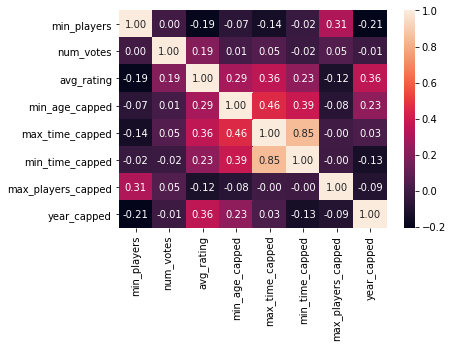

In [16]:
# Check whether the quantitative features have correlation
sns.heatmap(df_rated.corr(),annot=True, fmt = '0.2f')

# Full model

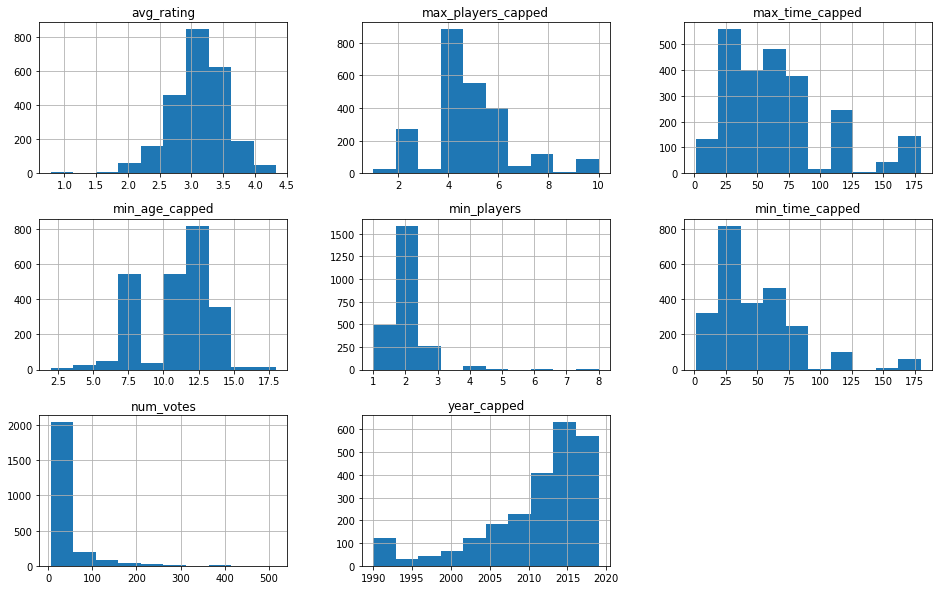

In [17]:
# Explore basic distributions, with the new capped features
# these are looking ok

df_rated.hist(figsize = (16,10));

In [18]:
# We have removed outliers and can see that only the 
# Category and Mechanic columns have NaNs in

df_rated.isna().mean()

name                  0.000000
designer              0.000000
artist                0.000000
publisher             0.000000
min_players           0.000000
category              0.772047
mechanic              0.051165
num_votes             0.000000
avg_rating            0.000000
min_age_capped        0.000000
max_time_capped       0.000000
min_time_capped       0.000000
max_players_capped    0.000000
year_capped           0.000000
dtype: float64

In [19]:
# This defines the linear regression function
def split_fit_and_score(num_cols, sample_weight=[]):
    '''
    This function takes a set of numerical columns in dataframe, 
    fits a linear model to those features and scores the resulting
    predictions.
    
    Arguments:
        num_cols      - a pandas dataframe of all the non-categorical 
                        columns that should be included in the fit.
                        Must also include one column named 'avg-rating'
                        to act as the y-variable.
        sample_weight - (optional) a pandas dataframe of length
                        num_cols.shape[0] that will act as the sample 
                        weight for the fit.  If none is supplied, a non-
                        weighted fit is carried out.
    Returns:
        
        X_cols        - a list of the column names included as X-variables
                        in the fit.
        train_score   - the R2 score for the training set
        test_score    - the R2 score for the test set
        lm_model      - the instance of the model
    
    
    
    '''
    # Create array of 1s for sample_weight if non provided
    if len(sample_weight)==0:
        sample_weight = [1]*num_cols.shape[0]
        
    X_cols = num_cols.columns.to_list()

    #Split into explanatory and response variables
    X = num_cols.drop('avg_rating',axis=1) # Drop avg_rating column
    y = num_cols['avg_rating']

    #Split into train and test
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, sample_weight,  test_size = .30, random_state=42) 

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train, sample_weight=w_train) #Fit

    #Predict off both the test set and the train set
    y_pred_test = lm_model.predict(X_test)
    y_pred_train = lm_model.predict(X_train)

    #Score
    train_score = r2_score(y_train,y_pred_train)
    test_score = r2_score(y_test,y_pred_test)
    if min(y_train)< 0 or max(y_train)>5 or min(y_test) < 0 or max(y_test) >5:
        print("#### Predicted y-value outside of range 0-5")
        
    return X_cols, train_score.round(3), test_score.round(3), lm_model


# This splits a df into numerical and categorical columns
def split_into_num_and_cat(df):
    '''
    This function splits the input dataframe into numerical columns and categorical columns.
    
    Arguments:
        df       - A pandas dataframe.
        
    Returns:
        num_cols - A pandas dataframe without any `object` type columns
        cat_cols - A pandas dataframe with only `object type columns
    '''
    
    num_cols = df.select_dtypes(exclude=['object'])
    cat_cols = df.select_dtypes(include=['object'])
    
    return num_cols, cat_cols
   

In [20]:
num_cols, cat_cols = split_into_num_and_cat(df_rated)

# Fit on the non-categorical columns
X_cols, train_score, test_score, lm_model = split_fit_and_score(num_cols)
print("Unweighted, numerical columns only: ",test_score, train_score)

# Weight by the number of votes the game has
X_cols, train_score, test_score, lm_model = split_fit_and_score(num_cols, sample_weight = num_cols.num_votes)
print("Weighted by num_votes, numerical columns only: ",test_score, train_score)

# Weight by the number of votes the game has (attempt to normalise num votes)
X_cols, train_score, test_score, lm_model = split_fit_and_score(num_cols, sample_weight = np.log(num_cols.num_votes))
print("Weighted by sqrt(num_votes), numerical columns only: ",test_score, train_score)



Unweighted, numerical columns only:  0.283 0.303
Weighted by num_votes, numerical columns only:  0.252 0.283
Weighted by sqrt(num_votes), numerical columns only:  0.28 0.301


It appears using sample weights based on the number of votes a game has does not improve the model.

We will now try to include some of the categorical variables as dummies and see if this improves the model.

The Categories and Mechanics columns can hold multiple values (as you can see from the df.head() above), separated by commas, so we have to split these out and create dummies.  As such, a single game (row) could have a non-zero dummy in multiple category_dummy columns.

In [21]:
# This function splits the multiple-choice columns into dummy variables for the top 10 options.
def create_top_10_dummies(df_column, df_names):
    '''
    This function splits the multiple-choice columns into dummy variables for the top 10 options.
    
    Arguments:
    df_column - The column to be split
    df_names  - The pandas dataframe which lists the human-readable names for the column values.
    
    Returns:
    df_out.   - A pandas dataframe containing on the dummy columns of the top 10 most 
                frequent options in the input column
    
    '''
    # Unpack multiple choice options
    # Find top 10 of each
    all_options = df_column.str.split(',',expand=True).stack().value_counts()
    top_10_options = all_options[:10].index.to_list()
    
    # Rename the lists
    rename_options = df_names.loc[top_10_options]['name'].to_dict()

    # Split the multiple choices on commas
    top_10_dummies_df  = df_column.str.get_dummies(sep=',')[top_10_options]
    # Rename the dummies to human-readable names and add a prefix
    top_10_dummies_df  = top_10_dummies_df.rename(columns=rename_options).add_prefix(df_column.name+'_')
    
    return top_10_dummies_df

In [22]:
top_10_cat_dummies_df  = create_top_10_dummies(df_rated.category, cats)
top_10_mech_dummies_df = create_top_10_dummies(df_rated.mechanic, mechs)

We now have human-readable dummy-variables for the top 10 of each of the categories and mechanics, we need to bring them into the same df

In [23]:
df_rated_with_cat = pd.concat([df_rated.drop(['category','mechanic'],axis=1),top_10_mech_dummies_df, top_10_cat_dummies_df],axis=1)



In [24]:
num_cols, cat_cols = split_into_num_and_cat(df_rated_with_cat)

X_cols, train_score, test_score, lm_model = split_fit_and_score(num_cols)
print("Unweighted, numerical columns only: ", test_score)
print("Slight improvement in R2: 0.283 -> 0.312")




Unweighted, numerical columns only:  0.312
Slight improvement in R2: 0.283 -> 0.312


One final thing we will try is to include a reduced version of the publisher column as a dummy_variables

In [25]:
# Change anything outside of the top 10 publishers to Other in preperation for dummying
df_rated_with_cat.loc[~df_rated_with_cat.publisher.isin(frequent_publisher),'publisher'] = 'Other'

In [26]:
# Adding dummies for the key publishers
df_publisher_dummies = pd.get_dummies(df_rated_with_cat.publisher, prefix='publisher_', drop_first=True)
df_rated_with_cat_and_pub = pd.concat([df_rated_with_cat.drop('publisher',axis=1),df_publisher_dummies], axis=1)
# Run the model again with publisher dummies in there too
num_cols = df_rated_with_cat_and_pub.select_dtypes(exclude=['object'])
cat_cols = df_rated_with_cat_and_pub.select_dtypes(include=['object'])

X_cols, train_score, test_score, lm_model = split_fit_and_score(num_cols)
print("Unweighted, numerical columns only: ", test_score, train_score)
print("Slight improvement in R2: 0.312 -> 0.329")



Unweighted, numerical columns only:  0.329 0.358
Slight improvement in R2: 0.312 -> 0.329


So all this means:  With an R^2 of 0.329, we can explain about 1/3rd of the variance in the ratings using the variables we have looked at so far in the dataset.

In [27]:
# We could investigate the coefficients of each feature 
# using the methods below

lm_model.intercept_;
zip(X_cols,lm_model.coef_);


Unfortunately `sklearn linear model` doesn't let you investigate the P-values of each coefficient. I could switch to `statsmodels.OLS` as this enables this output, but for this investigation, I will leave it there.

### Final thoughts

A few things have been on my mind while I've been working through this.
- Are linear regression models suitable for modelling a bounded continuous variable (i.e. here 0-5 but not outside this range).  I have accomodated this by checking during each prediction that the predicted y-values (ratings) do not fall outside of this range.
- There are still a few more categorical variables we could include in the model to see if they improve the fit.
- We dropped about 1,000 games from investigation because they were missing data from one of the columns we were using.  We could decide on a strategy to impute this missing data, to increase the number of games in the data set from ~2,500 to ~3,500.
- There may be a little more feature cleaning we could do (e.g. Fantasy Flight Games and Fantasy Flight Publishing may be the same publisher) 
- We have done little feature engineering to see if that can improve the fit (i.e. many of the numerical features are not nice normal distributions, so maybe a transformation of them could help)
- We have hinted at it with the age~time relationship, but this model should only be able to predict well if the relationships between rating and the X-features are themselves linear.  Say a good game needs to take more than 10 minutes, but less than 2-hours, a relationship like this is not accomodated in linear regression.  This may lend itself better to another approach, for example a tree-based approach where such conditionals are allowed.

My final thought is this, of all the games I have played and enjoyed in the past, I haven't been able to tell whether I would enjoy them from reading the minimum age and time-taken to play.  While oversimplified, this does hint at the fact that maybe these features just *don't affect* people's enjoyment of the game enough, and that there are other variables (not in the data set) that affect the rating more strongly.

TODO:
    
    Null

# Scratch